In [1]:
import torch
import sys
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [3]:
from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler

def get_balanced_sampler(dataset):
    # Count the number of images per class
    class_counts = [0] * 4  # Assuming 4 classes
    for _, label in dataset:
        class_counts[label] += 1

    # Weight for each sample
    weights = [1.0 / class_counts[label] for _, label in dataset]
    sampler = WeightedRandomSampler(weights, num_samples=4000, replacement=True)

    return sampler

def get_balanced_data_loader(data_dir, batch_size=256, num_workers=0):
    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])

    # Load the dataset with transformations
    train_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

    # Create a balanced sampler
    sampler = get_balanced_sampler(train_dataset)

    # Create the DataLoader with the sampler
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=num_workers)

    return train_loader

# Call the function with your dataset directory
train_loader = get_balanced_data_loader('/home/paritosh/workspace/IGTD_data/Results/Test_1', batch_size=128, num_workers=4)

In [4]:
# # checkpoint = torch.load('checkpoint_0040.pth.tar', map_location=device)
# checkpoint = torch.load('/home/paritosh/workspace/IGTD/runs/checkpoint_resnet18_0400.pth.tar', map_location=device)
# state_dict = checkpoint['state_dict']

# for k in list(state_dict.keys()):

#   if k.startswith('backbone.'):
#     if k.startswith('backbone') and not k.startswith('backbone.fc'):
#       # remove prefix
#       state_dict[k[len("backbone."):]] = state_dict[k]
#   del state_dict[k]

In [5]:
# Load the pretrained checkpoint
checkpoint = torch.load('/home/paritosh/workspace/IGTD/runs/checkpoint_resnet18_0500.pth.tar', map_location=device)
state_dict = checkpoint['state_dict']

# Create a new state_dict with modified keys
modified_state_dict = {}
for key, value in state_dict.items():
    if key.startswith('module.backbone.'):
        modified_key = key[len('module.backbone.'):]  # Remove the 'module.backbone.' prefix
        modified_state_dict[modified_key] = value
    elif key.startswith('module.'):
        modified_key = key[len('module.'):]  # Remove the 'module.' prefix
        modified_state_dict[modified_key] = value

# # Load the ResNet18 model
# model = torchvision.models.resnet18(pretrained=False, num_classes=4).to(device)

# # Load the modified state_dict into the model
# model.load_state_dict(modified_state_dict, strict=False)

In [6]:
 # Load the model (assuming it's a ResNet18 trained with SimCLR)
model = torchvision.models.resnet18(pretrained=False, num_classes=4).to(device)

# Modify the first layer to accept grayscale images
model.conv1 = torch.nn.Conv2d(1, model.conv1.out_channels, kernel_size=model.conv1.kernel_size,
                              stride=model.conv1.stride, padding=model.conv1.padding, bias=False)

# Move model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load the modified state_dict into the model
log = model.load_state_dict(modified_state_dict, strict=False)
assert log.missing_keys == ['fc.weight', 'fc.bias']

# log = model.load_state_dict(state_dict, strict=False)
# assert log.missing_keys == ['fc.weight', 'fc.bias']

/home/paritosh/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/paritosh/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# Modify the fully connected layer
model.fc = torch.nn.Identity()

# Now the model outputs the 512-dimensional embeddings from the AdaptiveAvgPool2d layer

In [9]:
# Set model to evaluation mode
model.eval()

# Disable gradient computation
with torch.no_grad():
    embeddings = []
    labels = []

    for images, batch_labels in train_loader:
        # Move images to the same device as the model
        images = images.to(device)

        # Forward pass to get embeddings
        batch_embeddings = model(images)

        # Store embeddings and labels
        embeddings.append(batch_embeddings.cpu().numpy())
        labels.append(batch_labels.numpy())

# Concatenate all collected embeddings and labels
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

In [10]:
print(embeddings.shape)
print(labels.shape)

(4000, 512)
(4000,)


In [11]:
# project embeddings into 2D space
# from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# pca = PCA(n_components=2)
# pca.fit(embeddings)
# pca_embeddings = pca.transform(embeddings)

tsne = TSNE(n_components=2, verbose=1)
tsne_embeddings = tsne.fit_transform(embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.001s...
[t-SNE] Computed neighbors for 4000 samples in 0.205s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.744559
[t-SNE] KL divergence after 50 iterations with early exaggeration: 86.155838
[t-SNE] KL divergence after 1000 iterations: 3.286732


VAT Processing:   6%|▋         | 254/3997 [00:04<01:04, 58.34it/s]

iVAT Processing: 100%|██████████| 3999/3999 [00:00<00:00, 28830.67it/s]


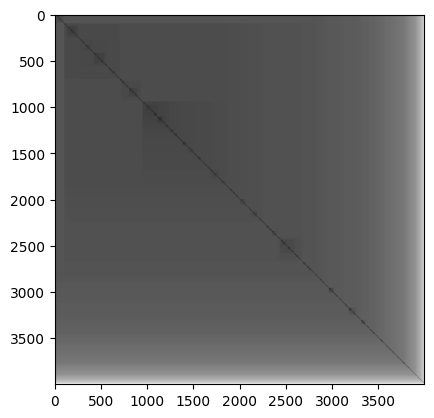

In [12]:
from VAT_library.iVAT import iVAT
from scipy.spatial.distance import cdist

# pairwise_dist = cdist(embeddings, embeddings)
# pairwise_dist = cdist(pca_embeddings, pca_embeddings)
pairwise_dist = cdist(tsne_embeddings, tsne_embeddings)

RiV, RV, reordering_mat = iVAT(pairwise_dist)

plt.imshow(RiV, cmap='gray')
save_path = "/home/paritosh/workspace/IGTD/runs/synthetic_easy_2D.png"  # Specify the path and file name here
plt.savefig(save_path)

In [18]:
# import pandas as pd
# from sklearn.utils import resample

# # Load the original dataset from the CSV file
# data = pd.read_csv('/home/paritosh/workspace/TabularDeath/synthetic_hard_data.csv')

# # Assuming 'target' is the column name for labels
# X = data.drop('label', axis=1)
# y = data['label']

# # Determine the number of samples per class
# samples_per_class = 14000 // 7  # Integer division to ensure equal number of samples per class

# sampled_dfs = []

# # Iterate over each unique class label
# for label in y.unique():
#     # Get the data points belonging to the current class
#     class_data = data[y == label]
    
#     # Sample the desired number of data points from the current class with replacement
#     sampled_class_data = resample(class_data, n_samples=samples_per_class, replace=True, random_state=42)
    
#     # Append the sampled data points to the sampled_data DataFrame
#     sampled_dfs.append(sampled_class_data)

# sampled_data = pd.concat(sampled_dfs, ignore_index=True)

# # Separate the features (X) and labels (y) from the sampled data
# sampled_X = sampled_data.drop('label', axis=1)
# sampled_y = sampled_data['label']

In [19]:
# print(sampled_X.shape)

# pairwise_dist = cdist(sampled_X, sampled_X)

# RiV, RV, reordering_mat = iVAT(pairwise_dist)

# plt.imshow(RiV, cmap='gray')
# save_path = "/home/paritosh/workspace/IK_contrastive_dataset/synthetic_hard/synthetic_hard_raw.png"
# plt.savefig(save_path)

In [20]:
# tsne = TSNE(n_components=2, verbose=1)
# tsne_embeddings = tsne.fit_transform(sampled_X)

# pairwise_dist = cdist(tsne_embeddings, tsne_embeddings)

# RiV, RV, reordering_mat = iVAT(pairwise_dist)

# plt.imshow(RiV, cmap='gray')
# save_path = "/home/paritosh/workspace/IK_contrastive_dataset/synthetic_hard/synthetic_hard_raw_2D.png"
# plt.savefig(save_path)